In [13]:
import statsmodels.api as sm
import pandas as pd #librería para manejo de datos
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

datos_f1=pd.read_csv('datos/Datos F1_noMulti.csv', sep=';', decimal=',', header=0)

datos_f1


,Tiempo Qualy (milisegundos),Length (m),Curva lenta,Curva media,Curva rapida,Presupuesto (mill. Euros),Asphalt Abrasion,log(aa),log(cl),log(cm),log(cr),A�o,Race,procentaje de tiempo con el acelerador a fondo,porcentaje de tiempo de frenada,Downforce,Tyre Stress,Lateral energy,Asphalt Grip
0,83.485,5.303,6,4,5,429.5,3,0.477121,0.778151,0.602060,0.698970,2017,Australia,64,13.0,4,1,2,1
1,81.879,5.303,6,4,5,350.0,3,0.477121,0.778151,0.602060,0.698970,2018,Australia,64,13.0,4,1,2,1
2,81.320,5.303,6,4,5,260.0,3,0.477121,0.778151,0.602060,0.698970,2019,Australia,64,13.0,4,1,2,1
3,69.687,5.412,3,7,2,429.5,5,0.698970,0.477121,0.845098,0.301030,2017,Bahrain,64,16.0,2,3,3,4
4,69.378,5.412,3,7,2,350.0,5,0.698970,0.477121,0.845098,0.301030,2018,Bahrain,64,16.0,2,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,67.778,4.309,1,6,7,350.0,3,0.477121,0.000000,0.778151,0.845098,2018,Brazil,60,16.0,4,3,4,3
59,67.508,4.309,1,6,7,260.0,3,0.477121,0.000000,0.778151,0.845098,2019,Brazil,60,16.0,4,3,4,3
60,97.328,5.554,8,5,4,429.5,2,0.301030,0.903090,0.698970,0.602060,2017,Abu Dhabi,60,17.0,3,2,3,2
61,95.589,5.554,8,5,4,350.0,2,0.301030,0.903090,0.698970,0.602060,2018,Abu Dhabi,60,17.0,3,2,3,2


In [14]:
list(datos_f1.columns)

['Tiempo Qualy (milisegundos)',
 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Presupuesto (mill. Euros)',
 'Asphalt Abrasion',
 'log(aa)',
 'log(cl)',
 'log(cm)',
 'log(cr)',
 'A�o',
 'Race',
 'procentaje de tiempo con el acelerador a fondo',
 'porcentaje de tiempo de frenada',
 'Downforce',
 'Tyre Stress',
 'Lateral energy',
 'Asphalt Grip']

In [15]:
X=datos_f1[[ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion']]
X = X.astype('float64')
y=datos_f1.values[:,0]
y = y.astype('float64')
#print(X)
mco1 = sm.OLS(y, sm.add_constant(X)).fit()

mco1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.78
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           2.85e-21
Time:                        10:10:20   Log-Likelihood:                -189.52
No. Observations:                  63   AIC:                             393.0
Df Residuals:                      56   BIC:                             408.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.6538      5.015      2.723      0.009       3.607      23.700
Length (m)          11.4054      0.978     11.661      0.000       9.446      13.365
Curva lenta          3.0251      0.343      8.808      0.000       2.337       3.713
Curva media         -1.4984      0.549     -2.728      0.008      -2.599      -0.398
Curva rapida         0.5889      0.400      1.472      0.147      -0.212       1.390
Asphalt Grip         4.1230      1.047      3.939      0.000       2.026       6.220
Asphalt Abrasion    -3.1871      0.880     -3.623      0.001      -4.949      -1.425
==============================================================================
Omnibus:                       32.534   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.414
Skew:                           1.651   Prob(JB):                     1.14e-16
Kurtosis:                       7.130   Cond. No.                         82.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
import numpy as np

beta=mco1.params
e=mco1.resid
beta=np.array(mco1.params)
#print(e)
sum(e**2)/(mco1.nobs-1)
print()
# sigmagorro=(np.dot(y, y)-np.dot(beta.T, np.dot(X.T, y))) / (mco1.nobs-1)
# print(sigmagorro)

## MULTICOLINEALIDAD

In [17]:
#Matriz de correlacciones
corr_matrix=np.corrcoef(X.T) #X.T = matriz X traspuesta
print(corr_matrix)

#Lo ideal es que la matriz fuese la identidad

[[ 1.          0.00753052  0.13372822  0.29054151  0.36949531  0.46805826]
 [ 0.00753052  1.         -0.06111079 -0.39084757 -0.50398903 -0.12775327]
 [ 0.13372822 -0.06111079  1.         -0.24789618  0.4831656   0.22624666]
 [ 0.29054151 -0.39084757 -0.24789618  1.          0.18379252  0.17162219]
 [ 0.36949531 -0.50398903  0.4831656   0.18379252  1.          0.59086427]
 [ 0.46805826 -0.12775327  0.22624666  0.17162219  0.59086427  1.        ]]


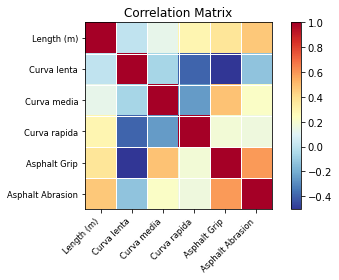

In [18]:
import statsmodels.graphics.api as smg
import matplotlib.pylab as plt
smg.plot_corr(corr_matrix, xnames=[ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion'])
plt.show()

In [19]:
import statsmodels.stats.outliers_influence as oi

#Para la primera variable
#1-(1-(R^2)) = 284 ; R = 0.9964
#Se podria decir que el tamanio dle edificio lo puedo escribir en funcion de las otas 2 variables

#Factor de inflacion de la varianza, con el for hacemos que salga  para toda las variables
vifs=[oi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#Hay problema de multicolinealidad, si vif es mayor que 10 y si es mayor que 20, problema grave
#HAY MULTICOLINEALIDAD
vifs

[41.28812918135159,
 7.949618256746982,
 19.351884667157172,
 6.36234153030487,
 20.563114067024074,
 13.616582053542007]

## HETEROSCEDASTICIDAD

In [20]:
GQ=sms.het_goldfeldquandt(mco1.model.endog, mco1.model.exog, split=3) #Split es para que se quede con una tercera parte o lo que queramos
print('Het-Goldfelquandt', GQ)#El SPLIT 3 no se puede poner porque debe dar un valor entero. Por defecto lo hace entre 2
#El vector te da en el 2 valor el p valor, si tu alfa es menor que el p valor significa HOMOSCEDASTICIDAD

BP=sms.het_breuschpagan(mco1.resid, mco1.model.exog)
print('Het-Breuschpagan', BP)
#Este nos decía cuanto dependía nuestros residuos al cuadrado respecto de nuestras vbles. Sólo nos interesan los
#dos ultimos valores que son el estadístico experimental y el p valor. Como es mayor que nuestro alfa (0.05) hay HOMOSCEDASTICIDAD
WH=sms.het_white(mco1.resid, mco1.model.exog)
print('Het-Whithe', WH) #Igual, nos interesan sólo los dos últimos valores y significan lo mismo que en el anterior. 



Het-Goldfelquandt (22.395983859110476, 8.91817819186668e-08, 'increasing')
Het-Breuschpagan (9.74808871156059, 0.13566929814691386, 1.7085238652767456, 0.13597834675774265)
Het-Whithe (20.702735884342026, 0.4148111973097286, 1.0278618786841114, 0.453548091635767)


### Glejser

In [21]:
#Glejser se hace "a mano" a cada bleble
headers = datos_f1.columns
header_maximo=""
alpha=0.05
h_max=0.0
r_max=0.0

elements = [ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion']

for indice in elements:
    print(indice)
    z=datos_f1[indice]
    z = z.astype('float64')
    for h in [-2,-1,-0.5,0.5,1,2]:
        mcoaux=sm.OLS(abs(mco1.resid),sm.add_constant((z**h))).fit()
        pval=mcoaux.pvalues[1]
        r2=mcoaux.rsquared
        #print("h: ", h, "-> pval:", pval, " R2: ", r2)
        #Nos debemos quedar con todas porque el pValor es menor que alfa, y de ellas escogemos la de R2 más grande
        #En este caso nos da el problema el Z^2, tenemos que multiplicar mis datos (la matriz) por 1/sqrt(Z^2)
        if((pval<alpha) and (r2>r_max)):
            r_max=r2
            header_max=indice
            h_max = h
    
z = datos_f1.values[:,13].astype('float64')
mcp = sm.WLS(y, sm.add_constant(X), weights=(1/np.sqrt(z**2))).fit() #Regresión por cuadrados ponderados

print("La variable: " + header_max + " elevado a ", h_max, " daba problema de heteroscedasticidad")
z = datos_f1[header_max].astype('float64')
mcp = sm.WLS(y, sm.add_constant(X), weights=(1/np.sqrt(z**h_max))).fit() #Regresión por cuadrados ponderados
mcp.summary()

Length (m)
Curva lenta
Curva media
Curva rapida
Asphalt Grip
Asphalt Abrasion
La variable: Asphalt Abrasion elevado a  2  daba problema de heteroscedasticidad


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            WLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     89.96
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           6.36e-27
Time:                        10:10:21   Log-Likelihood:                -181.22
No. Observations:                  63   AIC:                             376.4
Df Residuals:                      56   BIC:                             391.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.1570      3.549      3.426      0.001       5.048      19.266
Length (m)          11.9341      0.737     16.185      0.000      10.457      13.411
Curva lenta          2.7099      0.241     11.242      0.000       2.227       3.193
Curva media         -1.2861      0.478     -2.693      0.009      -2.243      -0.329
Curva rapida         0.2801      0.347      0.806      0.424      -0.416       0.976
Asphalt Grip         3.4334      0.973      3.529      0.001       1.484       5.382
Asphalt Abrasion    -2.3568      0.762     -3.094      0.003      -3.883      -0.831
==============================================================================
Omnibus:                       33.560   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.892
Skew:                           1.634   Prob(JB):                     3.68e-19
Kurtosis:                       7.654   Cond. No.                         68.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## AUTOCORRELACIÓN

In [24]:
from statsmodels.stats.stattools import durbin_watson
dw=durbin_watson(mcp.resid)
print("Durbin-Watson es ", dw)
rho= 1 - dw/2


mco_autocorr=sm.GLSAR(y, sm.add_constant(X), rho=rho) #Es para aplicar el algoritmo Lochrane-Orcutt o Praiss-Wistein 
#Y así resolver la autocorrelación. Para a la iteración 1000 y lo hace hasta que la diferencia entre rhos sea 10^-10
#mco_autocorr.summary()
res=mco_autocorr.iterative_fit(maxiter=100 , rtol=10**(-10))
res.summary()

Durbin-Watson es  1.8402520662727382


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                          GLSAR   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     47.94
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           4.26e-20
Time:                        10:10:58   Log-Likelihood:                -186.92
No. Observations:                  62   AIC:                             387.8
Df Residuals:                      55   BIC:                             402.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.3396      5.255      2.729      0.009       3.809      24.870
Length (m)          11.3766      1.025     11.094      0.000       9.322      13.432
Curva lenta          2.9910      0.359      8.342      0.000       2.272       3.710
Curva media         -1.5114      0.581     -2.602      0.012      -2.675      -0.347
Curva rapida         0.5559      0.420      1.325      0.191      -0.285       1.397
Asphalt Grip         4.0381      1.144      3.529      0.001       1.745       6.331
Asphalt Abrasion    -3.1645      0.947     -3.340      0.002      -5.063      -1.266
==============================================================================
Omnibus:                       33.875   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.989
Skew:                           1.728   Prob(JB):                     7.04e-18
Kurtosis:                       7.316   Cond. No.                         80.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## LINEALIDAD

## Test Harvey-Collier

In [43]:
import statsmodels.stats.diagnostic as diagn #Para el test de Harvey-Collier

diagn.linear_harvey_collier(res) # si nuestro alpha es menor que el p valor, hay linelidad, no se rechaza hipotesis nula

ValueError: "The initial regressor matrix, x[:skip], issingular. You must use a value of
skip large enough to ensure that the first OLS estimator is well-defined.


# Normalidad de los residuos

- Jarque-Bera: Test de hipótesis que contrasta si los datos de la muestra tienen el coeficiente de simetría y la curtósis de una distribución normal.
- $\chi^2$ (p-valor): p-valor del Test de Jaque-Bera.
- Skew: Coeficiente de Simetría de pearson de los residuos.
- Kurtosis: Coeficiente de apuntamiento de los residuos.
- Komogorov-Smirnov: Test de Hipótesis para contrastar si una muestra proviene de una distribución (en este caso normal).

In [35]:
import statsmodels.stats.api as sms
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
for i in range(4):
    print(name[i], test[i]) # para rechazar hipotesis nula de normalidad, tine que ser el pvlor mas cihco que 0.05 nuestro alpha
                            # para que sea simetrica tiene que ser 0 la skew
                            # para que la kurtosis sea normal tiene que ser de 4, es de 6 a asi que bueno

Jarque-Bera 76.76212656414955
Chi^2 two-tail prob. 2.1444504065430605e-17
Skew 1.6799857401403864
Kurtosis 7.23713423592888


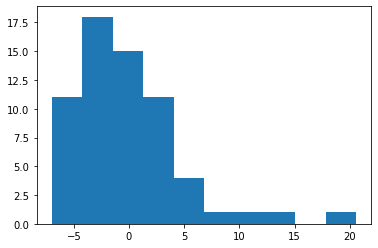

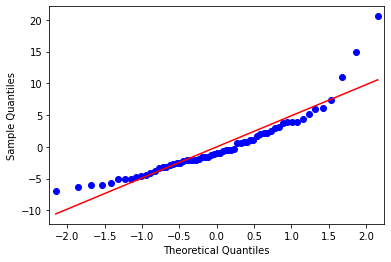

In [38]:
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

pyplot.hist(res.resid)
pyplot.show()
qqplot(res.resid, line='s')
pyplot.show()  # si los datos fueran normales estarian encima de mi linea roja, a si que no esta mal del todo

In [41]:
import statsmodels.stats.diagnostic as diag

diag.kstest_normal(mco1.resid)

(0.1255872908954349, 0.0224950792672523)

In [42]:
# es una forma de obtener intrvalos de confianza
from random import choices

beta=[]
n=len(y)
for it in range(10000): #repetimos 1000 veces la estimacion
    I=choices(list(range(n)), k=n) # elegimos una muestra con repeticion de los datos
    mco3 = sm.OLS(y[I], sm.add_constant(X.values[I,:])).fit() #ajustamos el modelo
    beta.append(list(mco3.params)) # guardamos los coeficientes
beta=np.array(beta)
k=len(X.T)+1
for i in range(k):
    q025=np.percentile(beta[:,i], 2.5) #percentil 2.5%
    q975=np.percentile(beta[:,i], 97.5) #percentil 97.5%
    media=np.mean(beta[:,i]) #media de los betas
    sd=np.std(beta[:,i]) #desviación tipica de los betas
    print(i, media,[q025, q975])

0 14.015513291345647 [4.740810826817497, 24.61853005666589]
1 11.340303168339904 [8.761315115313415, 13.499347449698652]
2 3.0165078690493883 [2.3840522531307906, 3.7515567812114123]
3 -1.5111707987383685 [-2.8348883381965635, -0.3727195185923825]
4 0.5730906604888649 [-0.14945089554514535, 1.252639100047552]
5 4.102154792108162 [1.480409315699042, 7.0084946168876545]
6 -3.120027708886139 [-4.658471292085566, -1.0944095936549036]
